In [ ]:
# !pip install colorama
from colorama import Fore, Style
# Basic imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import os
import re
import time
import random
import datetime
import warnings
from tqdm import tqdm

##################### Preprocessing imports 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders import TargetEncoder
from sklearn.impute import KNNImputer

##################### Models
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

#### Model selection 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingRegressor
from sklearn.inspection import permutation_importance
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from scipy.optimize import minimize
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor

##################### optuna library import
# !pip install shap
import optuna
import shap
import matplotlib.cm as cm
from collections import defaultdict
random_state = 42
n_splits = 5

<h2>Data Download</h2>
<ul><b>Tabular</b></ul>
<ul><b>Timeseries</b></ul>

In [37]:
######## Download the data 
train= pd.read_csv("../data/raw/train.csv")
test=pd.read_csv("../data/raw/test.csv")
sample = pd.read_csv('../data/raw/sample_submission.csv')
data_dict=pd.read_csv("../data/raw/data_dictionary.csv")

<h3> Basic configuration </h3>
<li>Map sii - map the target column in order to make the target data more clear</li>
<li>perform basic actions - such as dropping the id column across the datasets and applying the map for the dataset</li>

In [38]:
try:
    # Define Dependent and Target feature 
    target = 'sii'
    Target_series = train['sii']
    
    # Drop the id column from all dataset respectively 
    train_id, test_id = train['id'], test['id']
    train.drop(['id'], axis =1, inplace = True)
    test.drop(['id'], axis =1, inplace = True)
    data_dict = data_dict[data_dict['Field'].str.contains('id') == False]
    
except:
    print("Already dropped id or name column")
    

In [ ]:
def process_file(filename, dirname):
    '''
    Reads a parquet file from a specific address using the pandas library into a dataframe
    input: 
        filename - name of the file to read
        dirname - name of the directory which the file is located
    '''
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop(['step','battery_voltage','weekday'], axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df

######## Download the Tabular data 
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

100%|██████████| 2/2 [00:00<00:00,  9.87it/s]


Because we used the describe function we get the amount of data rows for every timeseries multiple time which is basically the same data

In [ ]:
train_ts = train_ts.drop(train_ts.iloc[:,1:10].columns,axis=1)
test_ts = test_ts.drop(test_ts.iloc[:,1:10].columns,axis=1)

<h1>Preprocessing action</h1>
<p>In this section I am creating all the necassries function for the feature engineering part of the tabular dataset </p>

In [48]:
# Concat the dataframe with it's target series (also work when trying to combine it with other series)
def concat_df_a_target(df,target):
    return pd.concat([df,target], axis=1)

def drop_Nans(train,subset):
    dropped_df = train.dropna(subset=subset).reset_index().drop('index',axis=1)
    return dropped_df

###### Find the difference in features between two dataframes (mainly train and test)
# Then return the new train set without it's unique column
def feature_difference(train, test):
    # Get the set of column names from each DataFrame
    train_set, test_set = set(train.columns), set(test.columns)
    # find the difference in cols
    feature_diff = train_set - test_set

    train = train.drop(list(feature_diff),axis=1)
    train = concat_df_a_target(train, Target_series)    

    return train


###### Outliers handling, the following three function will be used to handle outliers values in the dataset. 
# First function is for capping outliers using an algorithms 
# Second function is for capping outliers using domain knowledge
# Third function is to implement the process itself, which is combining the previous two functions
def cap_outliers(train, method='iqr', threshold=1.5):
    train_copy = train.copy()
    '''
    for the this tests I only want to remove outliers for some of the features and not all.
    For example if I am not cartefull the function will alter the target column 
    because of that it is important to set to change only the desired columns
    '''
    n_unique = train_copy.nunique()
    columns = n_unique[n_unique > 6].index.tolist()
    
    for col in columns:
        if col != 'sii':
            Q1 = train[col].quantile(0.25)
            Q3 = train[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR

            train_copy[col] = np.clip(train[col], lower_bound, upper_bound)
        
    return train_copy


# This function is not neccasry
def correct_outliers_dk(df):
    train = df.copy()
    # Define thresholds
    bmi_threshold = 7
    weight_threshold = 35
    diastolic_bp_threshold = 35
    systolic_bp_threshold = 65
    heart_rate_threshold = 45

    # Correct the outliers
    train.loc[train['Physical-BMI'] <= bmi_threshold, 'Physical-BMI'] = bmi_threshold
    train.loc[train['Physical-Weight'] <= weight_threshold, 'Physical-Weight'] = weight_threshold
    train.loc[train['Physical-Diastolic_BP'] < diastolic_bp_threshold, 'Physical-Diastolic_BP'] = diastolic_bp_threshold
    train.loc[train['Physical-Systolic_BP'] < systolic_bp_threshold, 'Physical-Systolic_BP'] = systolic_bp_threshold
    train.loc[train['Physical-HeartRate'] < heart_rate_threshold, 'Physical-HeartRate'] = heart_rate_threshold
    swap_condition = train['Physical-Diastolic_BP'] > train['Physical-Systolic_BP']
    train.loc[swap_condition, ['Physical-Diastolic_BP', 'Physical-Systolic_BP']] = train.loc[swap_condition, ['Physical-Systolic_BP', 'Physical-Diastolic_BP']].values
    
    return train


def handle_outliers(train): 
    '''
    The following function handle the outliers, both the statistical domain knowledge. 
    The function receives from the user 
    train - the train dataframe set
    '''
    
    train_capper = cap_outliers(train)
    train_capper = correct_outliers_dk(train_capper)
    display(train_capper.describe())
    
    return train_capper

###### Find high correlation pairs (pairs of features that have a correlation of over the threshold which currently stands on 95%)
# later on those features will be reduced in order to clean the data
def high_correlation_pairs(train, threshold=0.90):
    # Calculate the correlation matrix
    corr_matrix = train.select_dtypes(include='number').corr("pearson")
    
    # Select pairs of features with correlations above the threshold
    high_corr_pairs = (
        corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))  # Upper triangle without diagonal
        .stack()  # Convert to Series
        .reset_index()
    )
    
    # Rename columns for readability
    high_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
    
    # Filter by the correlation threshold (both positive and negative)
    high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'].abs() > threshold]
    
    # Display the high correlation pairs
    print("Highly correlated feature pairs (|correlation| > {}):".format(threshold))
    print(high_corr_pairs.to_string(index=False))
    
    return high_corr_pairs


def drop_high_cor_pairs(train,test):
    high_corr_pairs = high_correlation_pairs(train)
    # take the second feature from each pair and drop them from the dataframe
    features_to_remove = high_corr_pairs['Feature 2'].tolist()
    train = train.drop(features_to_remove, axis=1)
    test = test.drop(features_to_remove, axis=1)

    return train, test

# Find features with less then threshold correlation
def low_correlated_features(train, target_column, threshold=0.1):

    corr_matrix = train.corr()
    target_correlations = corr_matrix[target_column].abs()
    low_correlated_features = target_correlations[target_correlations < threshold].index
    return low_correlated_features


def imputing_missing_data(train, test):
    train_without_target = train.drop('sii', axis=1)
    imputer = KNNImputer(n_neighbors=5)
    train_imputed = imputer.fit_transform(train_without_target)
    test_imputed = imputer.transform(test)

    # Imputation converts the dataframe type to a numpy, therefore there is a need to restore that to its original data type
    train_imputed = pd.DataFrame(train_imputed, columns=train_without_target.columns)
    train_imputed = concat_df_a_target(train_imputed,Target_series)
    test_imputed = pd.DataFrame(test_imputed, columns=train_without_target.columns)
    return train_imputed, test_imputed

In [ ]:
def feature_engineering(df,tst):
    '''
    This function is used to clean the data and make sure it is ready for modeling.
    The function will only work on numerical features as the categorical will be studied separately and later on will unite
    The function works on a copy so it won't change the original training set and accidently cause data leakage
    input:
        df: the test dataframe
        tst: the train dataframe
    output:
        The processed train and test sets ready for modeling 
    '''
    
    train, test = df.copy(), tst.copy()
    ### Drop categorical columns 
    cat_cols = train.select_dtypes(exclude='number').columns
    train = train.drop(cat_cols,axis=1)
    cat_cols = test.select_dtypes(exclude='number').columns
    test = test.drop(cat_cols,axis=1)

    ### Drop unique columns for train dataframe
    train = feature_difference(train, test) 

    ### Deal with outliers
    train = handle_outliers(train)

    ### Handle missing values
    train, test = imputing_missing_data(train,test)
    train = train.dropna(subset='sii').reset_index().drop('index',axis=1)

    ### Feature creation 
    #feature_creation(train,test)

    ### Drop high correlation pairs
    train, test = drop_high_cor_pairs(train,test)
    
    ### Drop features with low correlation to target
    low_corr_cols = low_correlated_features(train.select_dtypes(include='number'),'sii')
    train, test = train.drop(low_corr_cols,axis=1), test.drop(low_corr_cols,axis=1)

    return train, test 

In [50]:
train_processed,test_processed = feature_engineering(train,test)

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
count,3960.000000,3960.000000,2421.000000,3022.000000,3027.000000,3076.000000,898.000000,2954.000000,2967.000000,2954.000000,...,1991.000000,1991.000000,1991.000000,1991.000000,475.000000,1721.000000,2609.000000,2606.000000,3301.000000,2736.000000
mean,10.426894,0.372727,65.093350,19.144650,55.946713,88.836099,27.151002,69.211747,81.569093,116.541300,...,18.017398,63.499017,31.179007,49.948860,2.178853,2.589550,40.875623,57.577322,1.060588,0.580409
std,3.554845,0.483591,11.775849,4.379203,7.473764,40.475990,5.176501,11.899103,13.465438,15.041578,...,6.786950,24.111157,13.107502,18.450158,0.849476,0.783937,9.766982,12.674429,1.094875,0.771122
min,5.000000,0.000000,35.000000,7.316511,33.000000,35.000000,18.000000,38.500000,45.000000,80.000000,...,4.635810,23.620100,4.655730,20.589200,0.660000,0.580000,17.000000,38.000000,0.000000,0.000000
25%,8.000000,0.000000,59.000000,15.869350,50.000000,57.200000,23.000000,61.000000,72.000000,107.000000,...,12.983150,45.204100,21.141550,35.887000,1.490000,2.020000,33.000000,47.000000,0.000000,0.000000
50%,10.000000,0.000000,65.000000,17.937682,55.000000,77.000000,26.000000,68.000000,81.000000,114.000000,...,16.438800,56.996400,27.415100,44.987000,2.010000,2.540000,39.000000,55.000000,1.000000,0.000000
75%,13.000000,1.000000,75.000000,21.571244,62.000000,113.800000,30.000000,76.000000,90.500000,125.000000,...,22.167600,77.105650,38.179400,60.271050,2.780000,3.160000,46.000000,64.000000,2.000000,1.000000
max,20.500000,1.000000,99.000000,30.124083,78.500000,198.700000,40.500000,98.500000,118.250000,152.000000,...,35.944275,124.957975,63.736175,96.847125,4.710000,4.790000,65.500000,89.500000,3.000000,3.000000


Highly correlated feature pairs (|correlation| > 0.9):
                  Feature 1                    Feature 2  Correlation
            Physical-Weight Physical-Waist_Circumference     0.938349
Fitness_Endurance-Max_Stage  Fitness_Endurance-Time_Mins     0.961852
               FGC-FGC_GSND                  FGC-FGC_GSD     0.937632
                FGC-FGC_SRL                  FGC-FGC_SRR     0.914091
                BIA-BIA_BMI                  BIA-BIA_FMI     0.927075
                BIA-BIA_BMI                  BIA-BIA_Fat     0.915142
                BIA-BIA_BMR                  BIA-BIA_ECW     0.970382
                BIA-BIA_BMR                  BIA-BIA_FFM     1.000000
                BIA-BIA_BMR                  BIA-BIA_ICW     0.971870
                BIA-BIA_BMR                  BIA-BIA_LDM     0.954629
                BIA-BIA_BMR                  BIA-BIA_LST     0.996208
                BIA-BIA_BMR                  BIA-BIA_SMM     0.966145
                BIA-BIA_BMR        

<h2>Combine sets - Numerical, Categorical and Timeseries summary</h2>
Combine the categrocial features dataset with the numerical features dataset
</br>
First I combine the numerical dataset I got from after performing preprocessing with the categorical features that I choose based on different metrics.
</br>
After that I take the new dataframe and add to it all the features from the Timeseries summary dataframe that I have created earlier using the parquet timeseries files.

In [ ]:
### Define the best categorical feature based on correlation to the target feature 
best_categorical_features = ["SDS-Season_Spring","SDS-Season_Winter","SDS-Season_Fall","CGAS-Season_Spring","SDS-Season_Summer",
                             "CGAS-Season_Winter","Fitness_Endurance-Season_Spring","CGAS-Season_Fall","BIA-Season_Fall","id"]

# Convert dataframes to dummies 
train_dummies = pd.get_dummies(train)
test_dummies = pd.get_dummies(test)
train_dummies['id'],test_dummies['id'] = train_id, test_id

# keep only the column that were defined in the beggining 
train_dummies = train_dummies.dropna(subset="sii").reset_index().drop('index',axis=1)
train_cat_best = train_dummies[best_categorical_features]
test_cat_best = test_dummies[best_categorical_features]

In [ ]:
# Concat between the categorical dataframe and the numerical dataframe 
train = pd.concat([train_processed, train_cat_best], axis=1, ignore_index=False)
test = pd.concat([test_processed, test_cat_best], axis=1, ignore_index=False)

In [ ]:
# Concat between tabular data and timeseries summary dataframe
try:
    train = train.merge(train_ts, on='id', how='left')
    train.drop(['id'], axis =1, inplace = True)
    train['accelerometer_data'] = train['stat_0'].notnull()
    
    test = test.merge(test_ts, on='id', how='left')
    test.drop(['id'], axis =1, inplace = True)
    test['accelerometer_data'] = test['stat_0'].notnull()

except:
    print("Already dropped id")

<h1> Evaluation </h1>
Evaluate the model using the QWK metric 

In [ ]:
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)


def TrainML(model_class, test_data):
    X = train.drop(['sii'], axis=1)
    y = train['sii']

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission

In [ ]:
Light = LGBMRegressor(verbose = -1)
XGB_Model = XGBRegressor()
CatBoost_Model = CatBoostRegressor(verbose = False)


voting_model = VotingRegressor(estimators=[
    ('lightgbm', Light),
    ('xgboost', XGB_Model),
    ('catboost', CatBoost_Model)
])

Submission = TrainML(voting_model, test)

Submission

Training Folds: 100%|██████████| 5/5 [01:12<00:00, 14.50s/it]

Mean Train QWK --> 0.9573
Mean Validation QWK ---> 0.3827


----> || Optimized QWK SCORE ::  0.435


,id,sii
0,00008ff9,2
1,000fd460,0
2,00105258,0
3,00115b9f,1
4,0016bb22,1
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,2
9,0083e397,2


<h2>Ensemble investigation</h2>
SHAP values and feature importance Insights

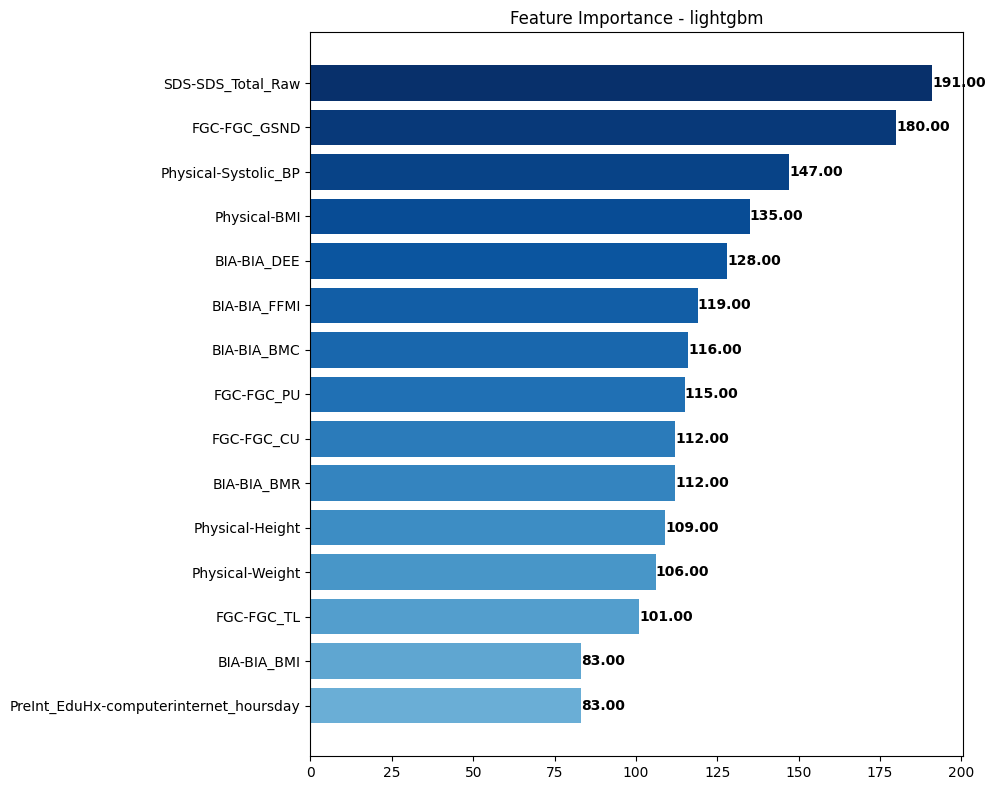

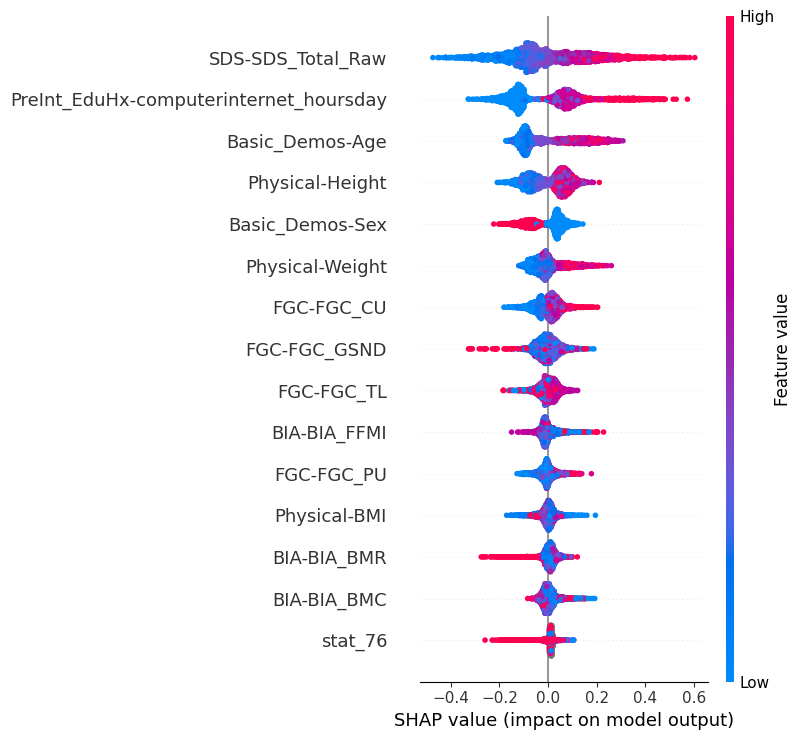

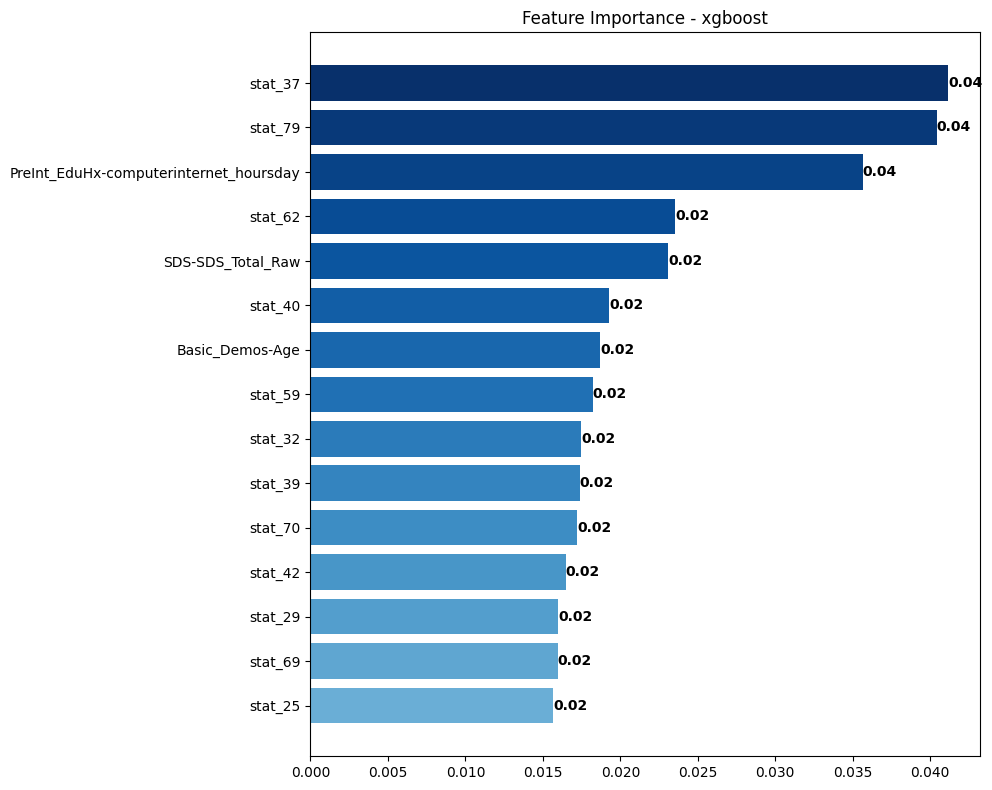

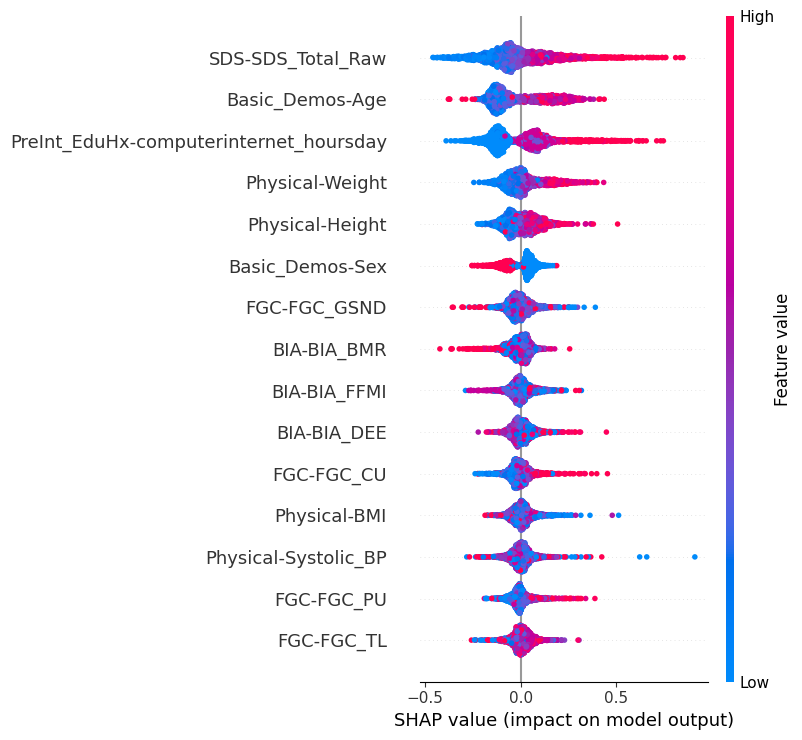

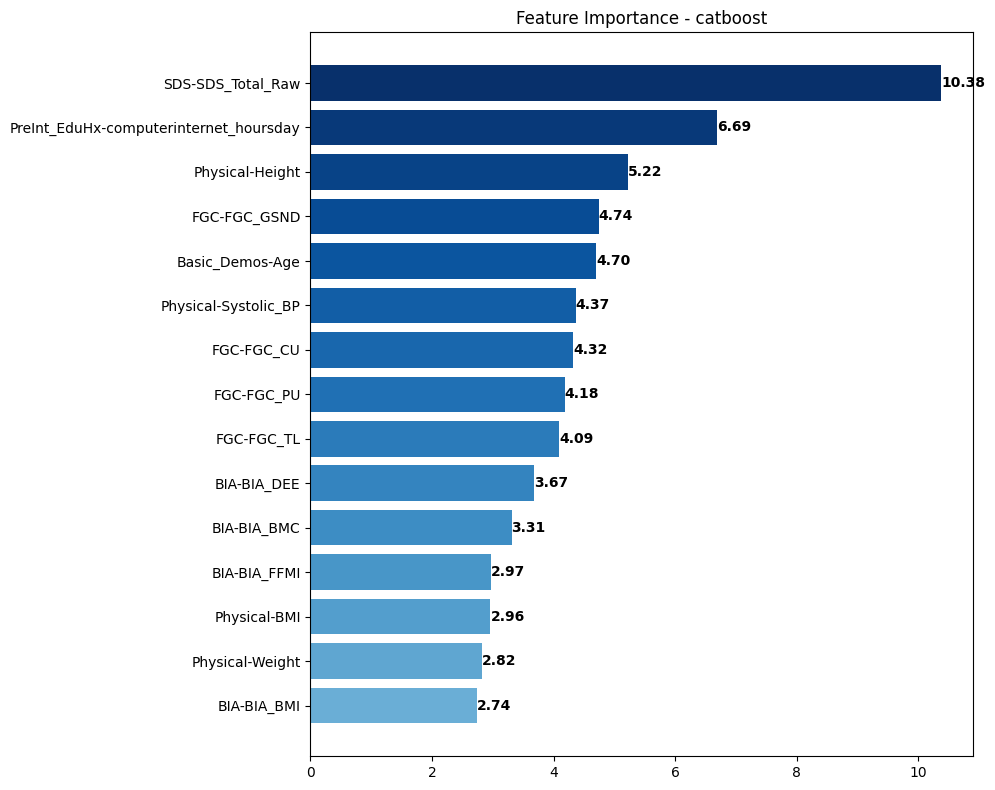

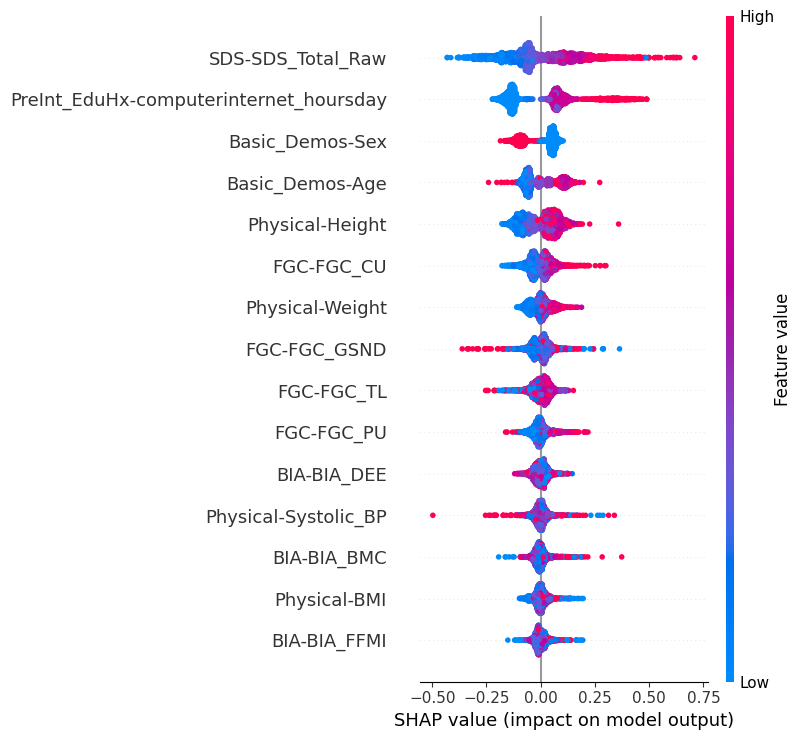

Most important features across all models:
1. SDS-SDS_Total_Raw
2. FGC-FGC_GSND
3. Physical-Systolic_BP
4. Physical-BMI
5. BIA-BIA_DEE
6. BIA-BIA_FFMI
7. BIA-BIA_BMC
8. FGC-FGC_PU
9. FGC-FGC_CU
10. BIA-BIA_BMR
11. Physical-Height
12. Physical-Weight
13. FGC-FGC_TL
14. PreInt_EduHx-computerinternet_hoursday
15. BIA-BIA_BMI

Least important features across all models:
1. stat_54
2. stat_77
3. stat_68
4. stat_65
5. stat_58
6. stat_55
7. stat_37
8. stat_78
9. stat_45
10. stat_48
11. stat_36
12. accelerometer_data
13. stat_75
14. stat_33
15. stat_35


In [ ]:
def analyze_ensemble_model(ensemble_model, X, y, n_top_features=15):
    feature_names = X.columns
    all_importances = defaultdict(list)

    def plot_feature_importance(importances, title, ax):
        indices = np.argsort(importances)[-n_top_features:]
        top_importances = importances[indices]
        top_features = [feature_names[i] for i in indices]
        
        colors = cm.Blues(np.linspace(0.5, 1, len(top_importances)))
        
        bars = ax.barh(top_features, top_importances, color=colors)
        ax.set_title(title)
        ax.set_yticks(range(len(top_features)))
        ax.set_yticklabels(top_features)
        
        for bar, imp in zip(bars, top_importances):
            ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{imp:.2f}', 
                    ha='left', va='center', color='black', fontweight='bold')

    def get_feature_importance(model):
        if hasattr(model, 'feature_importances_'):
            return model.feature_importances_
        elif isinstance(model, LinearRegression):
            return np.abs(model.coef_)
        else:
            return None

    def get_shap_values(model, X):
        if isinstance(model, (RandomForestRegressor)) or type(model).__name__ in ['LinearRegression','GradientBoostingRegressor','XGBRegressor', 'LGBMRegressor', 'CatBoostRegressor']:
            explainer = shap.TreeExplainer(model)
            return explainer.shap_values(X)    

    # Analysis for each model
    for name, model in ensemble_model.named_estimators_.items():
        fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))

        # Feature Importance Plot
        importances = get_feature_importance(model)
        if importances is not None:
            plot_feature_importance(importances, f"Feature Importance - {name}", ax1)
            for feature, importance in zip(feature_names, importances):
                all_importances[feature].append(importance)
        else:
            ax1.text(0.5, 0.5, "Feature importance not available", ha='center', va='center')

        plt.tight_layout()
        plt.show()

        # SHAP Values Beeswarm Plot
        try:
            shap_values = get_shap_values(model, X)
            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values, X, plot_type="dot", max_display=n_top_features, show=False)
            plt.show()
        except Exception as e:
            print(f"Error computing SHAP values for {name}: {e}")

    # Compute average importance across all models
    avg_importances = {feature: np.mean(importances) for feature, importances in all_importances.items()}
    sorted_features = sorted(avg_importances.items(), key=lambda x: x[1], reverse=True)

    # Get lists of most and least important features
    most_important = [feature for feature, _ in sorted_features[:n_top_features]]
    least_important = [feature for feature, _ in sorted_features[-n_top_features:]]

    print("Most important features across all models:")
    for i, feature in enumerate(most_important, 1):
        print(f"{i}. {feature}")

    print("\nLeast important features across all models:")
    for i, feature in enumerate(least_important, 1):
        print(f"{i}. {feature}")

    return most_important, least_important

# Usage
fitted_model = voting_model.fit(train.drop(["sii"],axis=1), train["sii"])
most_important, least_important = analyze_ensemble_model(fitted_model, train.drop(["sii"],axis=1), train["sii"])

In [ ]:
Submission.to_csv("submission.csv",index=False)